
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain Anual Weather Types (AWT) under future climate conditions

inputs required: 
  * Expected probabilities for each AWT under future climate conditions

outputs: 
    * CC_SST_AWTs_sim.nc
    * CC_SST_PCs_sim.nc

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime

# pip
import xarray as xr
import numpy as np
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.pca import PCA_LatitudeAverage
from teslakit.kma import KMA_simple, ClusterProbabilities
from teslakit.statistical import CopulaSimulation
from teslakit.alr import ALR_WRP

from teslakit.plotting.awt import Plot_AWTs_EOFs, Plot_AWTs, Plot_AWTs_Dates, Plot_AWTs_Validation
from teslakit.plotting.pcs import Plot_PCs_Compare_3D, Plot_PCs_WT
from teslakit.plotting.wts import Plot_Compare_Transitions

from teslakit.io.aux_nc import StoreBugXdset
from teslakit.util.time_operations import xds_reindex_daily, xds_reindex_monthly



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

site ='ROI'
p_data = r'/Users/albacid/Projects/TeslaKit_projects/sites/' + site + '/'

p_outputs = p_data + 'ClimateChange/'
import os
if not os.path.exists(p_outputs):
    os.makedirs(p_outputs)
    

In [3]:
# --------------------------------------
# load data and set parameters

# Load historical AWTs
SST_AWTs = xr.open_dataset(p_data + 'SST/SST_KMA.nc')
bmus_hist = SST_AWTs.bmus.values[:] + 1 # for plotting comparison


# Load SST PCs123 random generated with Copulas
pickle_in = open(p_data + 'SST/SST_dPCs_fit.pickle',"rb")
PCs_fit = pickle.load(pickle_in)

pickle_in = open(p_data + 'SST/SST_dPCs_rnd.pickle',"rb")
PCs_rnd = pickle.load(pickle_in)


# SST Predictor PCA parameters
pca_year_ini = 1880
pca_year_end = 2016
pca_month_ini = 6
pca_month_end = 5
num_clusters = 6

# New AWT probabilities (expected probabilities under rcp8.5)
WT_probs_new = [13.34, 12.07, 19.51, 12.49, 25.19, 17.40] # must sum 100%

# Simulation
num_PCs_rnd = 1000
n_sims = 10
y1_sim = 1700
y2_sim = 2700


## Present & Future AWT probabilities

In [4]:
# Get probability of each AWT (just for info)
set_values = np.arange(num_clusters) + 1
WT_probs = ClusterProbabilities(bmus_hist, set_values)*100 

print('current AWT probabilities')
print(WT_probs)
print(np.sum(WT_probs)) 

print('future AWT probabilities')
print(WT_probs_new)
print(np.sum(WT_probs_new))

current AWT probabilities
[13.14 13.14 18.98 13.87 20.44 20.44]
100.0
future AWT probabilities
[13.34, 12.07, 19.51, 12.49, 25.19, 17.4]
100.0


## Generate synthetic bmus with future probabilities


In [5]:
# bmus generation

WT_probs_new = [i/ 100 for i in WT_probs_new] 
WT_probs_cumsum = np.cumsum(WT_probs_new)

time_sim = [datetime(y, pca_month_ini,1) for y in range(y1_sim-1, y2_sim+1)]

bmus_sim = np.zeros((len(time_sim), n_sims), dtype=int) * np.nan

for s in range(n_sims):

    c = 0
    while c < len(time_sim):

        nrnd = np.random.rand()
        ind_col = np.where(WT_probs_cumsum > nrnd)[0][0]

        bmus_sim[c, s] = ind_col + 1
        c += 1


        
# Obtain AWT probabilities of the generated bmus

WT_probs_sim = np.zeros((n_sims, num_clusters)) * np.nan

for s in range(n_sims):
    WT_probs_sim[s,:] = ClusterProbabilities(bmus_sim[:,s], set_values)*100

print(WT_probs_sim)
print('----------')

# Obtain mean values of AWT probs from all simulations
WT_probs_sim_mean = np.mean(WT_probs_sim, axis=0)
print(WT_probs_sim_mean)

# Compare with expected values
WT_probs_new = [i* 100 for i in WT_probs_new] 
print(WT_probs_new)
print(WT_probs_sim_mean - WT_probs_new)
print('----------')
print(WT_probs_sim_mean - WT_probs)
print(WT_probs_new - WT_probs)



[[15.37 14.27 18.16 12.38 24.55 15.27]
 [14.47 13.07 16.87 13.87 23.85 17.86]
 [12.57 14.97 19.76 11.18 22.65 18.86]
 [12.87 13.57 17.86 12.18 26.45 17.07]
 [12.97 12.08 21.06 12.48 23.95 17.47]
 [13.87 11.48 19.36 10.58 26.05 18.66]
 [12.87 12.97 18.36 14.37 22.85 18.56]
 [12.97 12.48 19.06 13.17 24.95 17.37]
 [15.77 11.48 18.36 11.58 26.75 16.07]
 [15.17 13.07 19.86 14.07 21.46 16.37]]
----------
[13.89 12.94 18.87 12.58 24.35 17.36]
[13.34, 12.07, 19.51, 12.49, 25.19, 17.4]
[ 0.55  0.87 -0.64  0.09 -0.84 -0.04]
----------
[ 0.75 -0.19 -0.11 -1.28  3.91 -3.08]
[ 0.2  -1.07  0.53 -1.38  4.75 -3.04]


In [6]:
# Save

SST_AWTs_sim = xr.Dataset(
    {
        'evbmus_sims' : (('time','n_sim'), bmus_sim.astype(int)),
    },
    coords = {
        'time' : time_sim,
        'n_sim' : range(n_sims),
    },
)


StoreBugXdset(SST_AWTs_sim, p_outputs + 'CC_SST_AWT_sim.nc')


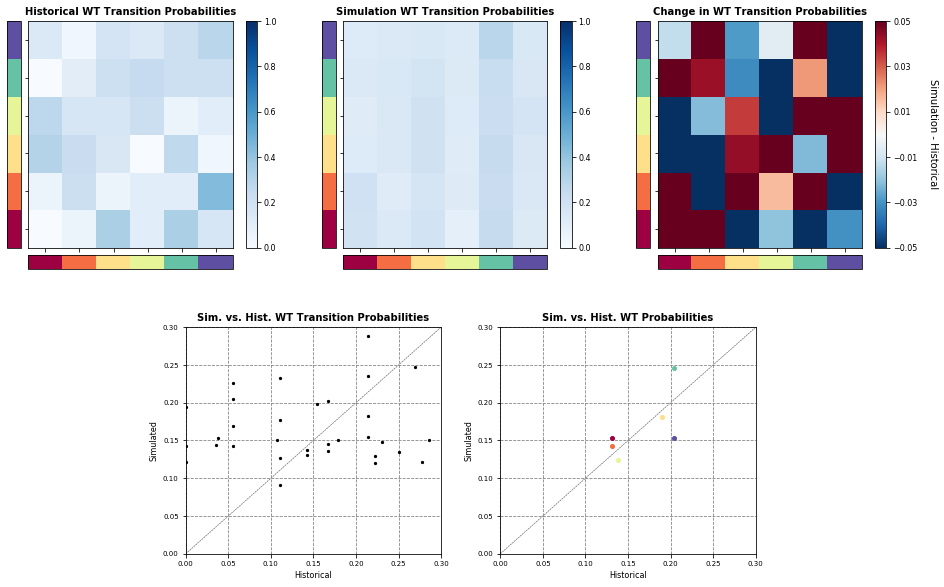

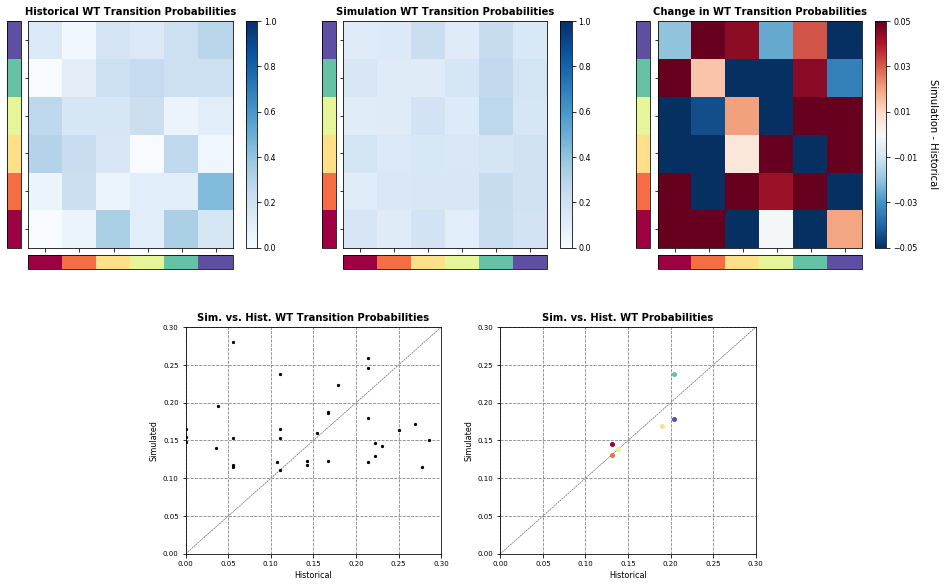

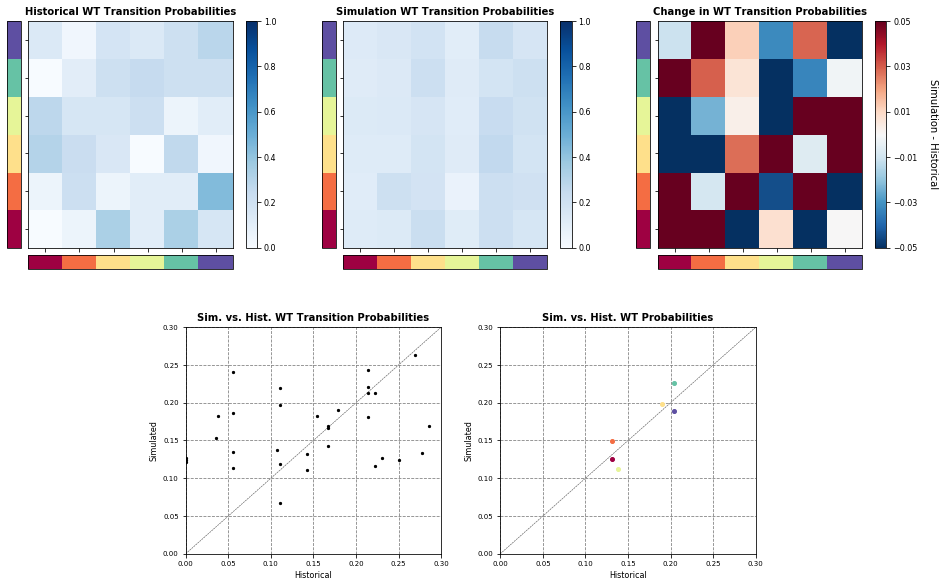

In [7]:

for s in SST_AWTs_sim.n_sim[:3]:
    
    bmus_values_sim = SST_AWTs_sim.evbmus_sims.sel(n_sim=s).values

    Plot_Compare_Transitions(num_clusters, bmus_hist, bmus_values_sim,
                                 sttl=None, show=True)

In [8]:
# --------------------------------------
# PCs generation

vari = SST_AWTs.variance.values[:]

# solve each ALR simulation
l_PCs_sim = []
for s in SST_AWTs_sim.n_sim:

    evbmus_sim = SST_AWTs_sim.sel(n_sim=s).evbmus_sims.values[:]

    # generate random PCs
    pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
    for c, m in enumerate(evbmus_sim):
        options = PCs_rnd['{0}'.format(int(m))]
        r = np.random.randint(options.shape[0])
        pcs123_sim[c,:] = options[r,:]
        
    # denormalize simulated PCs
    PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(vari[0]))
    PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(vari[1]))
    PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(vari[2]))

    # append simulated PCs
    l_PCs_sim.append(
        xr.Dataset(
            {
                'PC1'  : (('time',), PC1_sim),
                'PC2'  : (('time',), PC2_sim),
                'PC3'  : (('time',), PC3_sim),
                'evbmus_sim' : (('time',), evbmus_sim),
            },
            {'time' : SST_AWTs_sim.evbmus_sims.time.values}
        )
    )

# concatenate simulations
SST_PCs_sim = xr.concat(l_PCs_sim, 'n_sim')
print(SST_PCs_sim)

# store simulated PCs
StoreBugXdset(SST_PCs_sim, p_outputs + 'CC_SST_PCs_sim.nc')

# resample to daily and store
xds_d = xds_reindex_daily(SST_PCs_sim)
StoreBugXdset(xds_d, p_outputs + 'CC_SST_PCs_sim_d.nc')

# resample to monthly and store
xds_m = xds_reindex_monthly(SST_PCs_sim)
StoreBugXdset(xds_m, p_outputs + 'CC_SST_PCs_sim_m.nc')

        
        


<xarray.Dataset>
Dimensions:     (n_sim: 10, time: 1002)
Coordinates:
  * time        (time) object 1699-06-01 1700-06-01 ... 2699-06-01 2700-06-01
Dimensions without coordinates: n_sim
Data variables:
    PC1         (n_sim, time) float64 61.48 -37.93 -18.47 ... 2.315 1.127 18.69
    PC2         (n_sim, time) float64 -17.11 0.05244 19.58 ... 23.11 -4.516
    PC3         (n_sim, time) float64 20.9 1.64 -6.306 ... 11.17 4.996 -15.77
    evbmus_sim  (n_sim, time) int64 1 6 4 3 1 5 1 3 1 6 ... 2 3 6 2 3 2 3 5 4 3
